<div style="text-align:center; color:green; font-weight:bold;">
   Model Training notebook.
</di  

### Importing packages

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

### Creating useful functions for trainning and models evalution

In [15]:
def report(name, y_test, y_pred_test):
    print(f'{name} Test RMSE:', mean_squared_error(y_test, y_pred_test, squared=False))
    print(f'{name} Test R^2:', r2_score(y_test, y_pred_test))

In [16]:
def linear_regression(X_train, y_train, show_report=True):
    # Trainning the model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Predicting
    y_pred_test = lr_model.predict(X_test)
    
    # Evaluation
    if show_report:
        report('Linear Regression', y_test, y_pred_test)

def random_forest(X_train, y_train, show_report=True):
    # training the random forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # using the model for prediction
    y_pred_test = rf_model.predict(X_test)

    # evaluating the model's performance
    if show_report:
        report('Random Forest', y_test, y_pred_test)

def gradient_boost(X_train, y_train, show_report=True):
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_model.fit(X_train, y_train)

    y_pred_test = gb_model.predict(X_test)
    
    # evaluating the model's performance
    if show_report:
        report('Gradient Boost', y_test, y_pred_test)
        
def xgboost(X_train, y_train, show_report=True):
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)

    
    y_pred_test = xgb_model.predict(X_test)


    if show_report:
        report('XGBoost', y_test, y_pred_test)

### Feature Engineering

In [17]:
# reading the data
df = pd.read_csv("LivreDA.csv", on_bad_lines='warn', sep=";")

In [18]:
# verifying if there is no null values
print(df.isnull().sum())

bookID                    0
title                     0
authors                   0
average_rating            0
isbn                      0
language_code             0
  num_pages               0
ratings_count             0
text_reviews_count        0
publication_date          0
publisher                 0
Unnamed: 11           11071
dtype: int64


Adding new column that represents autors

In [19]:
# printing the dataframe head (only two rows)
df.head(2)

,bookID,title,authors,average_rating,isbn,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Unnamed: 11
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,NaN
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,eng,870,2153167,29221,09/01/2004,Scholastic Inc.,NaN


In [20]:
# droping the useless column 'Unnamed: 11'
df=df.drop(columns=['Unnamed: 11'])

In [21]:
# converting publication date to datetime with error handling
df['publication_date'] = pd.to_datetime(df['publication_date'], format="%m/%d/%Y", errors='coerce')

# Parsing different date formats
formats = ["%m/%d/%Y", "%d/%m/%Y"]
for fmt in formats:
    temp_dates = pd.to_datetime(df['publication_date'], format=fmt, errors='coerce')
    df['publication_date'] = df['publication_date'].combine_first(temp_dates)

In [22]:
df['publication_date']

0       2006-09-16
1       2004-09-01
2       2003-11-01
3       2004-05-01
4       2004-09-13
           ...    
11066   2004-12-21
11067   1988-12-01
11068   1993-08-01
11069   2007-02-27
11070   2006-05-28
Name: publication_date, Length: 11071, dtype: datetime64[ns]

In [23]:
df[df['publication_date'].isna()]

,bookID,title,authors,average_rating,isbn,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
8146,31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,553575104,eng,718,10608,295,NaT,Bantam Books
11042,45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,fre,640,15,2,NaT,Folio histoire


In [24]:
# dropping the rows where publication date is nan after conversion to datetime
df.drop([8146,11042], inplace = True)

In [25]:
df.isna().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

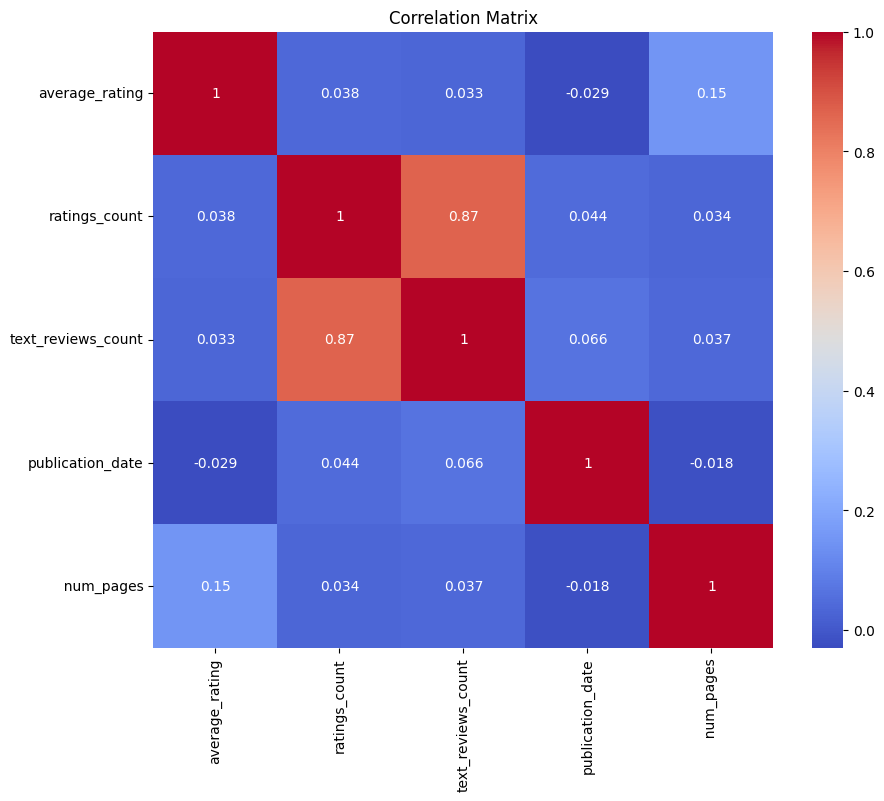

In [26]:
# Calculating correlation matrix before adding any numerical columns
correlation_matrix = df[['average_rating', 'ratings_count', 'text_reviews_count', "publication_date", "  num_pages"]].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

<span style="color:orange; font-weight:bold">We can see that average rating does not have a high correlation with any of the numerical column, a small correlation with num_pages of 0.15
</span>

#### Adding numerical columns

In [27]:
train_data = df.copy()

In [28]:
author_counts = train_data['authors'].value_counts().to_dict()
train_data['author_popularity'] = df['authors'].map(author_counts)

In [29]:
train_data['publication_year'] = pd.to_datetime(df['publication_date']).dt.year.astype(int)
train_data['publication_month'] = pd.to_datetime(df['publication_date']).dt.month.astype(int)
train_data['publication_day'] = pd.to_datetime(df['publication_date']).dt.day.astype(int)

In [30]:
train_data['publisher_freq'] = train_data['publisher'].map(train_data['publisher'].value_counts()) / len(train_data)

In [32]:
train_data['title_length'] = train_data['title'].apply(len)

In [33]:
train_data.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher', 'author_popularity',
       'publication_year', 'publication_month', 'publication_day',
       'publisher_freq', 'title_length'],
      dtype='object')

In [34]:
train_data[['average_rating', 'title_length', 'publisher_freq', 'publication_year','publication_month', 'publication_day', '  num_pages']].describe()

,average_rating,title_length,publisher_freq,publication_year,publication_month,publication_day,num_pages
count,11069.000000,11069.000000,11069.000000,11069.000000,11069.000000,11069.000000,11069.000000
mean,3.933431,35.659680,0.004232,2000.157015,6.542777,11.260909,336.206613
std,0.350800,23.587661,0.006330,8.258972,3.413326,10.280422,241.141466
min,0.000000,2.000000,0.000090,1900.000000,1.000000,1.000000,0.000000
25%,3.770000,18.000000,0.000452,1998.000000,4.000000,1.000000,192.000000
50%,3.960000,30.000000,0.001717,2003.000000,7.000000,8.000000,299.000000
75%,4.130000,47.000000,0.005059,2005.000000,9.000000,20.000000,416.000000
max,5.000000,254.000000,0.028729,2020.000000,12.000000,31.000000,6576.000000


* The num of pages column seem to have some outliers, we will check and remove for book with less than 10 pages

In [35]:
# showing the books with less than 10 pages
train_data[train_data['  num_pages'] <10]

,bookID,title,authors,average_rating,isbn,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,author_popularity,publication_year,publication_month,publication_day,publisher_freq,title_length
10,16,The Hitchhiker's Guide to the Galaxy (Hitchhik...,Douglas Adams/Stephen Fry,4.22,739322206,eng,6,1266,253,2005-03-23,Random House Audio,1,2005,3,23,0.002981,75
215,524,Lord of the Flies,William Golding,3.68,307281701,eng,6,408,96,2005-10-11,Listening Library (Audio),5,2005,10,11,0.000452,17
306,955,The 5 Love Languages / The 5 Love Languages Jo...,Gary Chapman,4.70,802415318,eng,0,22,4,2005-01-01,Moody Publishers,1,2005,1,1,0.000542,51
324,1053,The Richest Man in Babylon,George S. Clason,4.26,1419349996,eng,4,86,15,2005-06-17,Recorded Books Inc.,2,2005,6,17,0.000542,26
329,1090,Purpose Driven Life - For Commuters: What on E...,Rick Warren,3.93,310258979,eng,5,26,2,2005-03-15,Zondervan,2,2005,3,15,0.001174,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10917,44979,Howards End,E.M. Forster/Nadia May,3.96,786168471,eng,9,32,16,2007-06-01,Blackstone Audiobooks,1,2007,6,1,0.000994,11
10952,45161,The Roald Dahl Audio Collection,Roald Dahl,4.41,61214965,en-US,4,199,36,2007-02-20,HarperCollins Publishers,16,2007,2,20,0.004246,31
11024,45465,Artemis Fowl (Artemis Fowl #1),Eoin Colfer/Nathaniel Parker,3.84,1400085918,eng,6,55,14,2004-04-06,Listening Library,1,2004,4,6,0.000271,31
11025,45472,Treasury of American Tall Tales: Volume 1: Dav...,David Bromberg/Jay Ungar/Molly Mason/Garrison ...,3.86,739336509,eng,0,36,9,2006-08-22,Listening Library (Audio),1,2006,8,22,0.000452,117


In [36]:
# removing books with less than 10 pages
train_data=train_data[train_data['  num_pages'] >10]

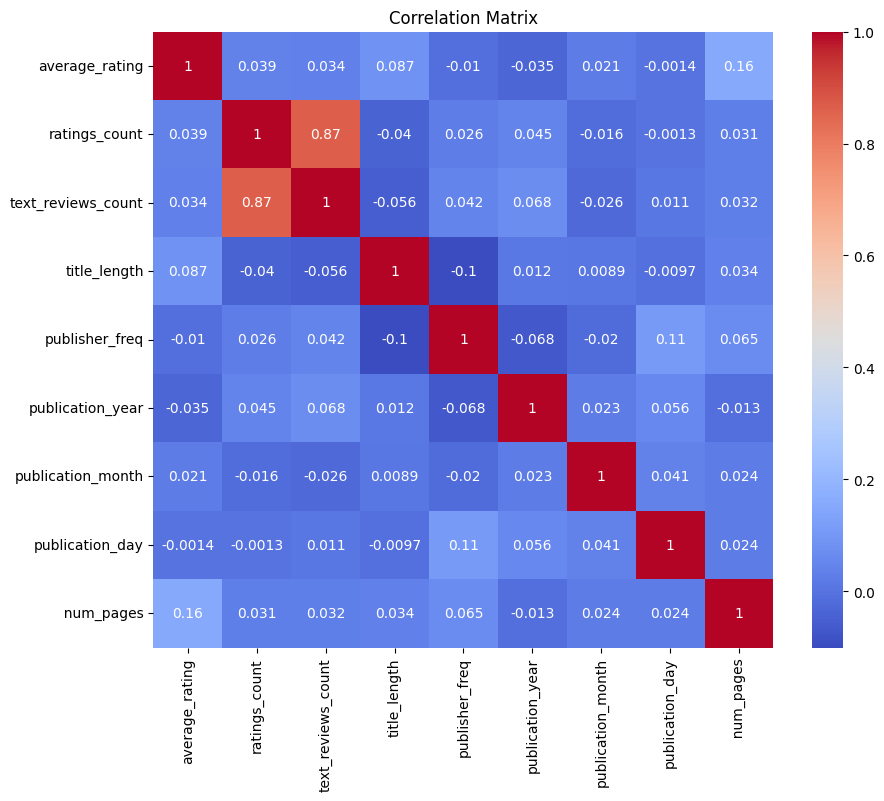

In [37]:
# Correlation matrix after adding multiple numerical columns
correlation_matrix = train_data[[ 'average_rating','ratings_count', 'text_reviews_count','title_length', 'publisher_freq', 'publication_year','publication_month', 'publication_day', '  num_pages']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- We can see than still the correlation with average rating is low

In [38]:
# we are only keeping the year month and day and dropping the date

In [39]:
train_data=train_data.drop(['publication_date'], axis=1)

In [40]:
train_data.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher',
       'author_popularity', 'publication_year', 'publication_month',
       'publication_day', 'publisher_freq', 'title_length'],
      dtype='object')

### Model Training and evaluation

#### 1. keeping all the language codes variations

In [41]:
# Creating a copy of training data
train_data_1 = train_data.copy()

In [42]:
train_data.language_code.unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'ita',
       'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale'],
      dtype=object)

In [43]:
# One-hot encoding for language_code
train_data_1 = pd.get_dummies(train_data_1, columns=['language_code'], drop_first=True)

In [44]:
train_data_1.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', '  num_pages',
       'ratings_count', 'text_reviews_count', 'publisher', 'author_popularity',
       'publication_year', 'publication_month', 'publication_day',
       'publisher_freq', 'title_length', 'language_code_ara',
       'language_code_en-CA', 'language_code_en-GB', 'language_code_en-US',
       'language_code_eng', 'language_code_enm', 'language_code_fre',
       'language_code_ger', 'language_code_gla', 'language_code_glg',
       'language_code_grc', 'language_code_ita', 'language_code_jpn',
       'language_code_lat', 'language_code_msa', 'language_code_mul',
       'language_code_nl', 'language_code_nor', 'language_code_por',
       'language_code_rus', 'language_code_spa', 'language_code_swe',
       'language_code_tur', 'language_code_wel', 'language_code_zho'],
      dtype='object')

In [45]:
# Standardizing data ensures that each feature contributes equally to the model, preventing features with larger scales (like ratings_count) 
# from dominating features with smaller scales (like publication_month and average_rating)
numerical_features = ['ratings_count', 'text_reviews_count','title_length', 'publisher_freq', 'publication_year','publication_month', 'publication_day', '  num_pages']
scaler = StandardScaler()
train_data_1[numerical_features] = scaler.fit_transform(train_data_1[numerical_features])

In [46]:
# we only keep numerical columns for the training
X = train_data_1.drop(columns=['bookID', 'title', 'authors', 'average_rating', 'isbn','publisher'])
y = train_data_1['average_rating']

# we are splitting the data set to 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
linear_regression(X_train, y_train)

Linear Regression Test RMSE: 0.35522338624633953
Linear Regression Test R^2: 0.018214975941200362


In [48]:
random_forest(X_train, y_train)

Random Forest Test RMSE: 0.29854767748117944
Random Forest Test R^2: 0.3065092108345566


In [49]:
gradient_boost(X_train, y_train)

Gradient Boost Test RMSE: 0.30843821380958786
Gradient Boost Test R^2: 0.259799009177907


In [50]:
xgboost(X_train, y_train)

XGBoost Test RMSE: 0.32833898675225087
XGBoost Test R^2: 0.16120040808563763


#### 2. keeping only unique language codes

In [51]:
train_data_2 = train_data.copy()

In [52]:
train_data_2['language_code'] = train_data_2['language_code'].replace({'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng'})

In [53]:
train_data_2.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'language_code',
       '  num_pages', 'ratings_count', 'text_reviews_count', 'publisher',
       'author_popularity', 'publication_year', 'publication_month',
       'publication_day', 'publisher_freq', 'title_length'],
      dtype='object')

In [54]:
train_data_2 = pd.get_dummies(train_data_2, columns=['language_code'], drop_first=True)

In [55]:
train_data_2.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', '  num_pages',
       'ratings_count', 'text_reviews_count', 'publisher', 'author_popularity',
       'publication_year', 'publication_month', 'publication_day',
       'publisher_freq', 'title_length', 'language_code_ara',
       'language_code_eng', 'language_code_enm', 'language_code_fre',
       'language_code_ger', 'language_code_gla', 'language_code_glg',
       'language_code_grc', 'language_code_ita', 'language_code_jpn',
       'language_code_lat', 'language_code_msa', 'language_code_mul',
       'language_code_nl', 'language_code_nor', 'language_code_por',
       'language_code_rus', 'language_code_spa', 'language_code_swe',
       'language_code_tur', 'language_code_wel', 'language_code_zho'],
      dtype='object')

In [56]:
X = train_data_2.drop(columns=['bookID', 'title', 'authors', 'average_rating', 'isbn', 'publisher'])
y = train_data_2['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [57]:
linear_regression(X_train, y_train)

Linear Regression Test RMSE: 0.3550724896872901
Linear Regression Test R^2: 0.019048910425511933


In [58]:
random_forest(X_train, y_train)

Random Forest Test RMSE: 0.30183651174953396
Random Forest Test R^2: 0.2911459098468705


In [59]:
gradient_boost(X_train, y_train)

Gradient Boost Test RMSE: 0.3098982968493088
Gradient Boost Test R^2: 0.25277450378349675


In [60]:
xgboost(X_train, y_train)

XGBoost Test RMSE: 0.32897960614849836
XGBoost Test R^2: 0.15792406552137228


#### 3. Keeping only book with less than 2000 pages

In [61]:
train_data_3 = train_data_2.copy()

In [62]:
train_data_3 = train_data_3[(train_data_3['  num_pages'] <= 2000)]

In [63]:
X = train_data_3.drop(columns=['bookID', 'title', 'authors', 'average_rating', 'isbn','publisher'])
y = train_data_3['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
linear_regression(X_train, y_train)

Linear Regression Test RMSE: 0.35193846824037167
Linear Regression Test R^2: 0.041006774436003535


In [65]:
random_forest(X_train, y_train)

Random Forest Test RMSE: 0.32199515239503
Random Forest Test R^2: 0.19724923660365734


In [66]:
gradient_boost(X_train, y_train)

Gradient Boost Test RMSE: 0.3226495090637788
Gradient Boost Test R^2: 0.19398323056390143


In [67]:
xgboost(X_train, y_train)

XGBoost Test RMSE: 0.3362963511981852
XGBoost Test R^2: 0.12435843036434824


#### 4. Keeping books between year 1990 and 2010

In [68]:
train_data_4 = train_data_3.copy()

In [69]:
train_data_4 = train_data_4[(train_data_4['publication_year'] >= 1990) & (train_data_4['publication_year'] <= 2010)]

In [70]:
X = train_data_4.drop(columns=['bookID', 'title', 'authors', 'average_rating', 'isbn','publisher'])
y = train_data_4['average_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
linear_regression(X_train, y_train)

Linear Regression Test RMSE: 0.33670577240403615
Linear Regression Test R^2: 0.03580139390837478


In [72]:
random_forest(X_train, y_train)

Random Forest Test RMSE: 0.32281956199670314
Random Forest Test R^2: 0.11369119590400778


In [73]:
gradient_boost(X_train, y_train)

Gradient Boost Test RMSE: 0.3181092976810749
Gradient Boost Test R^2: 0.13936678880256115


In [74]:
xgboost(X_train, y_train)

XGBoost Test RMSE: 0.3408343406323689
XGBoost Test R^2: 0.012011097454781128


<span style="color:red; font-weight:bold">The best R^2 we have so far is 30% that means we need to do more data cleaning and we also need to add more rows or columns to our dataset that have better correlation with the average rating ~~
</span>